# 네이버 영화 평점 분석

In [1]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import urllib
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# plot 시 한글이 깨지는 현상 방지!

import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system!!') 

##### 2019년 의 영화 평점 데이터를 가져옵니다.

In [3]:
import time

# date = pd.date_range('20190101', periods=365, freq='D')
date = pd.date_range('20190101', periods=31, freq='D')

movie_date = []
movie_name = []
movie_point = []

for today in date:
    html = "http://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=cur&date={date}"
    response = urlopen(html.format(date=
                                   urllib.parse.quote(today.strftime('%Y%m%d'))))
    soup = BeautifulSoup(response, "html.parser")
    
    end = len(soup.find_all('td', 'point'))
    
    movie_date.extend([today for n in range(0, end)])
    movie_name.extend([soup.find_all('div', 'tit5')[n].a.string for n in range(0, end)])
    movie_point.extend([soup.find_all('td', 'point')[n].string for n in range(0, end)])
    time.sleep(1)

In [4]:
# 수집된 데이터 건수 확인
len(movie_date), len(movie_name), len(movie_point)

(1237, 1237, 1237)

In [5]:
movie = pd.DataFrame({'date':movie_date, 
                      'name':movie_name, 
                      'point':movie_point})
movie.head()

,date,name,point
0,2019-01-01,보헤미안 랩소디,9.49
1,2019-01-01,헌터 킬러,9.43
2,2019-01-01,폴란드로 간 아이들,9.42
3,2019-01-01,트루먼 쇼,9.32
4,2019-01-01,점박이 한반도의 공룡2 : 새로운 낙원,9.24


In [6]:
# 인터넷의 문제로 미리 수집된 데이터를 이용합니다.
# 2019년 네이버 영화 평점 리스트(2019년 네이버 영화 평점 리스트.csv 파일이용)를 movie 변수로 불러옵니다.
movie = pd.read_csv("../data/2019년 네이버 영화 평점 리스트.csv")
movie.head()

,date,name,point
0,2019-01-01,보헤미안 랩소디,9.49
1,2019-01-01,헌터 킬러,9.43
2,2019-01-01,폴란드로 간 아이들,9.42
3,2019-01-01,트루먼 쇼,9.32
4,2019-01-01,점박이 한반도의 공룡2 : 새로운 낙원,9.24


In [7]:
# 데이터 프레임의 컬럼 정보를 확인합니다.
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16011 entries, 0 to 16010
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    16011 non-null  object 
 1   name    16011 non-null  object 
 2   point   16011 non-null  float64
dtypes: float64(1), object(2)
memory usage: 375.4+ KB


In [8]:
# date 컬럼을 datetime 타입으로 변경합니다.
# movie['date'].astype('datetime64')
movie['date'] = pd.to_datetime(movie['date'], format='%Y-%m-%d %H:%M:%S', errors='raise')
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16011 entries, 0 to 16010
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    16011 non-null  datetime64[ns]
 1   name    16011 non-null  object        
 2   point   16011 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 375.4+ KB


In [9]:
# 영화별 평점 평균을 계산합니다.
movie.pivot_table(values = ['point'], index=['name'], aggfunc=['mean'])

,mean
,point
name,
0.0MHz,5.604231
1919 유관순,8.449024
28일 후,7.906774
47미터 2,7.244756
4월 이야기,8.190000
...,...
호텔 뭄바이,9.318500
홀리 모터스,7.560294


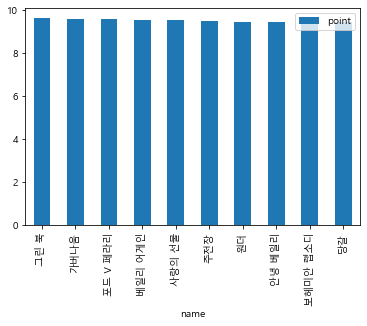

<Figure size 432x216 with 0 Axes>

In [10]:
# 평균 평점이 높은 10개 영화를 시각화합니다.
movie.pivot_table(values = 'point', index='name', aggfunc='mean').sort_values(by='point', ascending=False).head(10).plot(kind='bar')
plt.figure(figsize=(6,3))
plt.show()

In [11]:
# 평균 평점이 낮은 10개 영화를 시각화합니다.
movie.pivot_table(values = ['point'], index=['name'], aggfunc='mean').sort_values('point').head(10)

,point
name,
킹 오브 프리즘 -샤이니 세븐 스타즈-,2.008889
행동하는 양심 김대중,3.044444
얼굴없는 보스,3.437000
나랏말싸미,3.534694
자전차왕 엄복동,4.047692
극장판 엉덩이 탐정: 화려한 사건 수첩,4.149535
천안함 프로젝트,4.330000
시선,4.340000
봉신연의: 영웅의 귀환,4.866000


In [12]:
# 영화별 평점 건수(리뷰 요일)를 계산합니다.
movie.pivot_table(values = ['point'], index=['name'], aggfunc='count')

,point
name,
0.0MHz,26
1919 유관순,82
28일 후,31
47미터 2,82
4월 이야기,19
...,...
호텔 뭄바이,40
홀리 모터스,34
황혼에서 새벽까지,26


In [13]:
# 평점 건수(리뷰 요일)가 높은 10개 영화를 시각화합니다.
movie.pivot_table(values = ['point'], index=['name'], aggfunc='count').sort_values('point', ascending=False).head(10)

,point
name,
교회오빠,226
기생충,214
그린 북,183
인생 후르츠,172
가버나움,164
일일시호일,156
알라딘,153
주전장,146
극한직업,131


In [14]:
# 평점 건수(리뷰 요일)가 낮은 10개 영화를 시각화합니다.
movie.pivot_table(values = ['point'], index=['name'], aggfunc='count').sort_values('point').head(10)

,point
name,
나쁜 나라,1
라스베가스를 떠나며,1
명탐정 코난 : 제로의 집행인,1
그때 그사람들,1
수상한 그녀,1
리즈와 파랑새,1
분노의 질주: 언리미티드,1
인천상륙작전,1
럭키,1


In [15]:
# 평균 평점이 높은 순서대로 영화 정보를 추출합니다.
tmp = movie.pivot_table(values = ['point'], index=['name'], aggfunc='mean').sort_values('point', ascending=False).index
tmp

Index(['그린 북', '가버나움', '포드 V 페라리', '베일리 어게인', '사랑의 선물', '주전장', '원더', '안녕 베일리',
       '보헤미안 랩소디', '당갈',
       ...
       '우상', '봉신연의: 영웅의 귀환', '시선', '천안함 프로젝트', '극장판 엉덩이 탐정: 화려한 사건 수첩',
       '자전차왕 엄복동', '나랏말싸미', '얼굴없는 보스', '행동하는 양심 김대중', '킹 오브 프리즘 -샤이니 세븐 스타즈-'],
      dtype='object', name='name', length=494)

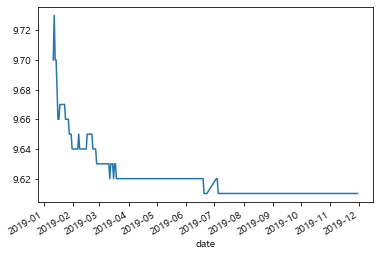

In [16]:
# 평균 평점 1위 영화의 평점 변화를 시각화합니다.
movie.pivot_table(values = 'point', index='date', columns='name')[tmp[0]].dropna().plot()
plt.show()

In [17]:
# 모든 영화에 대해 날짜별 평점 변화를 계산합니다.
movie.pivot_table(values = 'point', index='date', columns='name')

name,0.0MHz,1919 유관순,28일 후,47미터 2,4월 이야기,500일의 썸머,7년-그들이 없는 언론,7번방의 선물,80일간의 세계일주,82년생 김지영,...,헬보이,현기증,혈투,호두까기 인형과 4개의 왕국,호랑이보다 무서운 겨울손님,호텔 뭄바이,홀리 모터스,황혼에서 새벽까지,히트,"힘을 내요, 미스터 리"
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,8.52,NaN,NaN,NaN,...,NaN,NaN,NaN,7.39,NaN,NaN,NaN,NaN,9.1,NaN
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,8.52,NaN,NaN,NaN,...,NaN,NaN,NaN,7.40,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.40,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.40,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.40,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# 평점이 없는 경우 (na의 경우) 0으로 치환합니다.
movie.pivot_table(values = 'point', index='date', columns='name').fillna(0)


name,0.0MHz,1919 유관순,28일 후,47미터 2,4월 이야기,500일의 썸머,7년-그들이 없는 언론,7번방의 선물,80일간의 세계일주,82년생 김지영,...,헬보이,현기증,혈투,호두까기 인형과 4개의 왕국,호랑이보다 무서운 겨울손님,호텔 뭄바이,홀리 모터스,황혼에서 새벽까지,히트,"힘을 내요, 미스터 리"
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.0,0.0,0.0,0.0,0.0,0.0,8.52,0.0,0.0,0.00,...,0.0,0.0,0.0,7.39,0.0,0.0,0.0,0.0,9.1,0.0
2019-01-02,0.0,0.0,0.0,0.0,0.0,0.0,8.52,0.0,0.0,0.00,...,0.0,0.0,0.0,7.40,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,7.40,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,7.40,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,7.40,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,6.69,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,6.69,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,6.69,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# date 컬럼에서 년, 월, 일, 요일 정보를 추출합니다.
# from datetime import datetime
movie['year'] = movie['date'].dt.year
movie['month'] = movie['date'].dt.month
movie['day'] = movie['date'].dt.day
movie['wday'] = movie['date'].dt.weekday
movie['week'] = movie['date'].dt.weekofyear
movie

,date,name,point,year,month,day,wday,week
0,2019-01-01,보헤미안 랩소디,9.49,2019,1,1,1,1
1,2019-01-01,헌터 킬러,9.43,2019,1,1,1,1
2,2019-01-01,폴란드로 간 아이들,9.42,2019,1,1,1,1
3,2019-01-01,트루먼 쇼,9.32,2019,1,1,1,1
4,2019-01-01,점박이 한반도의 공룡2 : 새로운 낙원,9.24,2019,1,1,1,1
...,...,...,...,...,...,...,...,...
16006,2019-12-31,대통령의 7시간,6.18,2019,12,31,1,1
16007,2019-12-31,쥬만지: 넥스트 레벨,6.13,2019,12,31,1,1
16008,2019-12-31,백두산,5.93,2019,12,31,1,1
16009,2019-12-31,아내를 죽였다,5.18,2019,12,31,1,1


In [20]:
# 영화의 요일별 평균 평점을 계산합니다.
movie.pivot_table(values = 'point', index=['name','wday'])

point
name         wday          
0.0MHz       0     5.522500
             1     5.482500
             2     5.697500
             3     5.592500
             4     5.587500
...                     ...
힘을 내요, 미스터 리 2     7.585000
             3     7.619000
             4     7.613333
             5     7.602000
             6     7.602222

[3165 rows x 1 columns]

In [21]:
# 인덱스를 재설정합니다. reset_index함수 이용
movie.pivot_table(values = 'point', index=['name','wday']).reset_index()

,name,wday,point
0,0.0MHz,0,5.522500
1,0.0MHz,1,5.482500
2,0.0MHz,2,5.697500
3,0.0MHz,3,5.592500
4,0.0MHz,4,5.587500
...,...,...,...
3160,"힘을 내요, 미스터 리",2,7.585000
3161,"힘을 내요, 미스터 리",3,7.619000
3162,"힘을 내요, 미스터 리",4,7.613333
3163,"힘을 내요, 미스터 리",5,7.602000


In [22]:
# 영화의 주별 평균 평점을 계산합니다.
movie.pivot_table(values = 'point', index=['name','week'])

point
name         week          
0.0MHz       22    6.026000
             23    5.844286
             24    5.515714
             25    5.235000
             26    5.118000
...                     ...
힘을 내요, 미스터 리 44    7.560000
             45    7.570000
             46    7.570000
             47    7.570000
             48    7.570000

[2902 rows x 1 columns]

In [23]:
# 인덱스를 재설정합니다. reset_index함수 이용
movie.pivot_table(values = 'point', index=['name','week']).reset_index()

,name,week,point
0,0.0MHz,22,6.026000
1,0.0MHz,23,5.844286
2,0.0MHz,24,5.515714
3,0.0MHz,25,5.235000
4,0.0MHz,26,5.118000
...,...,...,...
2897,"힘을 내요, 미스터 리",44,7.560000
2898,"힘을 내요, 미스터 리",45,7.570000
2899,"힘을 내요, 미스터 리",46,7.570000
2900,"힘을 내요, 미스터 리",47,7.570000


In [24]:
# 영화별 주차를 계산합니다.
movie.pivot_table(values = 'month', index='name',aggfunc='count').loc['기생충']

month    214
Name: 기생충, dtype: int64

In [30]:
#  평균 평점 10위 영화의 이름을 추출합니다
tmp = movie.pivot_table(values = ['point'], index=['name'], aggfunc='mean').sort_values('point', ascending=False).index
top_10 = tmp[0:10]
top_10

Index(['그린 북', '가버나움', '포드 V 페라리', '베일리 어게인', '사랑의 선물', '주전장', '원더', '안녕 베일리',
       '보헤미안 랩소디', '당갈'],
      dtype='object', name='name')

In [31]:
#  평균 평점 10위 영화의 월별 평균 평점을 계산합니다.
top_10.pivot_table(values = 'point', index=['name','month'], aggfunc='mean')

AttributeError: 'Index' object has no attribute 'pivot_table'

## 시각화 그래프 3개 추려서... Visualization